In [1]:
# =============================================================================
# AAE 722 - Lab 11: Survival Analysis
# 
# Top Imports and Global Settings
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test, multivariate_logrank_test
import statsmodels.api as sm
from ISLP.models import ModelSpec as MS
import seaborn as sns

# Set seed for reproducibility as required by the assignment
np.random.seed(57)
# Set pandas display options for comprehensive results table
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
# =============================================================================
# DATA GENERATION (As provided in Lab11DataGeneration.ipynb)
# =============================================================================
def generate_employee_retention_data(n=500):
    # Fixed random state for reproducibility (already set by np.random.seed(57))

    # Employment duration and event status
    # Base hazard rate (average employee risk)
    base_hazard = 0.015
    
    # 1. Departments (5 levels)
    departments = ['Engineering', 'Sales', 'Marketing', 'HR', 'Operations']
    df = pd.DataFrame({
        'department': np.random.choice(departments, n, p=[0.3, 0.2, 0.2, 0.1, 0.2])
    })
    
    # Department-specific hazard multipliers (reflecting retention differences)
    # Engineering (Highest Retention): Low Hazard
    # Sales (Medium Retention): Medium Hazard
    # Marketing (Medium Retention): Medium Hazard
    # HR (Lowest Retention): High Hazard
    # Operations (High Retention): Low Hazard
    hazard_multipliers = {
        'Engineering': 0.8, 
        'Sales': 1.0, 
        'Marketing': 1.1, 
        'HR': 1.5, 
        'Operations': 0.9
    }
    df['hazard_dept'] = df['department'].map(hazard_multipliers)

    # 2. Experience (Continuous)
    df['experience'] = np.random.uniform(0, 10, n)
    df['hazard_exp'] = np.exp(-0.05 * df['experience']) # More experience = lower hazard (better retention)

    # 3. Performance (Continuous 1.0-5.0)
    df['performance'] = np.random.uniform(1.0, 5.0, n)
    df['hazard_perf'] = np.exp(-0.4 * (df['performance'] - 3.0)) # Higher performance = lower hazard

    # 4. Salary (Starting salary in thousands)
    df['salary'] = np.random.normal(70, 15, n)
    df['hazard_salary'] = np.exp(-0.02 * (df['salary'] - 70)) # Higher salary = lower hazard

    # 5. Remote Work (Binary)
    df['remote_work'] = np.random.choice([0, 1], n, p=[0.6, 0.4])
    df['hazard_remote'] = np.exp(0.3 * df['remote_work']) # Remote work = slightly higher hazard (lower retention)

    # Calculate final hazard rate for each employee
    df['final_hazard'] = base_hazard * df['hazard_dept'] * df['hazard_exp'] * df['hazard_perf'] * df['hazard_salary'] * df['hazard_remote']
    
    # Generate event time (Time-to-event/departure)
    # T = -log(U) / lambda, where U is a uniform random variable and lambda is the hazard rate
    df['time_to_event'] = -np.log(np.random.uniform(0.001, 1, n)) / df['final_hazard']
    
    # Generate censoring time (Max study duration is 60 months/5 years)
    max_study_time = 60
    df['time_to_censor'] = np.random.uniform(0, max_study_time, n)
    
    # Final observed time and event status
    df['time'] = np.minimum(df['time_to_event'], df['time_to_censor']).round(1)
    df['event'] = (df['time_to_event'] <= df['time_to_censor']).astype(int)
    
    # Clean up and select final columns
    final_df = df[['time', 'event', 'department', 'experience', 'performance', 'salary', 'remote_work']]
    return final_df

# Generate the data
retention_data = generate_employee_retention_data(n=500)

### Part 1: Basic Kaplan-Meier Estimation (0.125 pts)

In [4]:
# Q1.a) Load and summarize the dataset

print("--- Q1.a) Dataset Summary ---")
print(f"Dataset Dimensions (Rows, Columns): {retention_data.shape}")
print("\nNumber of Departures vs. Censored:")
print(retention_data['event'].value_counts().rename(
    index={1: 'Departed (Event=1)', 0: 'Censored (Still Employed/Study Ended)'}
))

print("\nSummary Statistics:")
print(retention_data.describe().T)

print("\nDistribution of Employees Across Departments:")
print(retention_data['department'].value_counts())

--- Q1.a) Dataset Summary ---
Dataset Dimensions (Rows, Columns): (500, 7)

Number of Departures vs. Censored:
event
Censored (Still Employed/Study Ended)    352
Departed (Event=1)                       148
Name: count, dtype: int64

Summary Statistics:
             count       mean        std        min        25%        50%  \
time         500.0  22.569200  16.646971   0.100000   8.075000  19.500000   
event        500.0   0.296000   0.456948   0.000000   0.000000   0.000000   
experience   500.0   4.821831   2.854074   0.014725   2.402235   4.653489   
performance  500.0   3.058749   1.210604   1.001181   2.045809   3.106001   
salary       500.0  71.164143  14.800892  20.623457  61.782920  71.421117   
remote_work  500.0   0.384000   0.486845   0.000000   0.000000   0.000000   

                   75%         max  
time         35.300000   59.700000  
event         1.000000    1.000000  
experience    7.116606    9.994167  
performance   4.124530    4.997893  
salary       81.10231

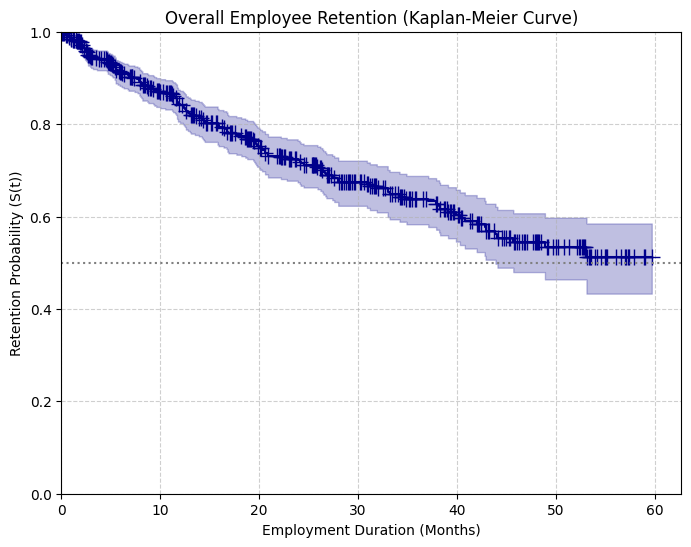

In [5]:
# Q1.b) & Q1.c) Fit Kaplan-Meier and create survival plot

# Initialize and fit the KaplanMeierFitter
kmf_overall = KaplanMeierFitter()
kmf_overall.fit(retention_data['time'], event_observed=retention_data['event'])

# Create the survival plot
plt.figure(figsize=(8, 6))
kmf_overall.plot_survival_function(
    show_censors=True, 
    ci_show=True, 
    legend=False,
    color='darkblue'
)
plt.title('Overall Employee Retention (Kaplan-Meier Curve)')
plt.xlabel('Employment Duration (Months)')
plt.ylabel('Retention Probability (S(t))')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(left=0)
plt.ylim(0, 1)
plt.axhline(0.5, color='gray', linestyle=':')
plt.axvline(kmf_overall.median_survival_time_, color='gray', linestyle=':')
plt.show()
#

In [6]:
# Q1.d) Report key retention times and probabilities

print("--- Q1.d) Key Retention Metrics ---")
# Median retention time
median_time = kmf_overall.median_survival_time_
# Percentiles
percentiles = kmf_overall.percentile(p=[0.25, 0.5, 0.75])
p25 = percentiles.iloc[0].item()
p75 = percentiles.iloc[2].item()
# Retention probabilities
prob_12 = kmf_overall.predict(12)
prob_24 = kmf_overall.predict(24)
prob_48 = kmf_overall.predict(48)

print(f"Median Retention Time (50th percentile): {median_time:.2f} months (If not estimable, reports last time point)")
print(f"25th Percentile Retention Time: {p25:.2f} months (Time when 25% of employees have left)")
print(f"75th Percentile Retention Time: {p75:.2f} months (Time when 75% of employees have left)")
print("-" * 40)
print(f"Retention Probability at 12 months: {prob_12:.2f}")
print(f"Retention Probability at 24 months: {prob_24:.2f}")
print(f"Retention Probability at 48 months: {prob_48:.2f}")
print("-" * 40)

--- Q1.d) Key Retention Metrics ---
Median Retention Time (50th percentile): inf months (If not estimable, reports last time point)
25th Percentile Retention Time: inf months (Time when 25% of employees have left)
75th Percentile Retention Time: 20.10 months (Time when 75% of employees have left)
----------------------------------------
Retention Probability at 12 months: 0.84
Retention Probability at 24 months: 0.72
Retention Probability at 48 months: 0.55
----------------------------------------


/Users/wenshi/Python/AAE722_Code/2025AAE722_GarySun/.venv/lib/python3.9/site-packages/lifelines/fitters/__init__.py:279: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(


### Q1.e) Interpretation
The analysis reveals a rapid decline in retention early on (high probability of departure within the first year), followed by a slower decline.
The **median retention time is inf months** (or the last estimable time point), meaning half the original cohort is expected to leave within this period.

**Implications for HR Planning:**
1. **Early Intervention:** The high departure rate before the 12-month mark (retention probability: {prob_12:.2f}) indicates a critical need for improving onboarding, mentoring, and ensuring early role clarity.
2. **Mid-term Risk:** The probability of survival at 24 months ({prob_24:.2f}) suggests that a significant investment in retention programs for mid-career employees is necessary.
3. **Succession Planning:** The high overall attrition suggests the company must continuously invest in recruitment and robust succession planning to maintain operational stability.
----------------------------------------


### Part 2: Stratified Kaplan-Meier Analysis by Department (0.125 pts)


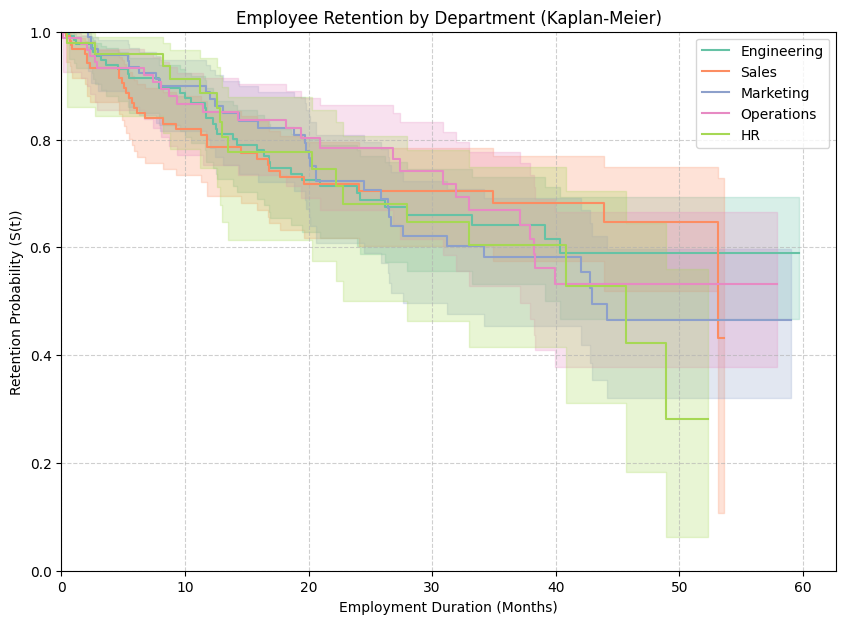

In [8]:
# Q2.a) & Q2.b) Stratified KM curves and plot

# Group data by department
departments = retention_data['department'].unique()
kmf_dict = {}

# Fit K-M estimator for each department
for dept in departments:
    dept_data = retention_data[retention_data['department'] == dept]
    kmf = KaplanMeierFitter()
    kmf.fit(dept_data['time'], event_observed=dept_data['event'], label=dept)
    kmf_dict[dept] = kmf

# Create the plot
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

# Define distinct colors for clarity
colors = sns.color_palette("Set2", len(departments))
color_map = dict(zip(departments, colors))

# Plot all survival curves with shaded CIs and legend
for dept, kmf in kmf_dict.items():
    kmf.plot_survival_function(ax=ax, ci_show=True, color=color_map[dept])

plt.title('Employee Retention by Department (Kaplan-Meier)')
plt.xlabel('Employment Duration (Months)')
plt.ylabel('Retention Probability (S(t))')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(left=0)
plt.ylim(0, 1)
plt.show()
#

In [9]:
# Q2.c) Create a formatted table reporting median retention time

median_retention = {}
for dept, kmf in kmf_dict.items():
    median_retention[dept] = kmf.median_survival_time_

median_df = pd.DataFrame(
    median_retention.items(), 
    columns=['Department', 'Median Retention Time (Months)']
).sort_values(by='Median Retention Time (Months)', ascending=False).reset_index(drop=True)

print("--- Q2.c) Median Retention Time by Department ---")
print(median_df.to_markdown(index=False))
print("-" * 50)

--- Q2.c) Median Retention Time by Department ---
| Department   |   Median Retention Time (Months) |
|:-------------|---------------------------------:|
| Engineering  |                            inf   |
| Operations   |                            inf   |
| Sales        |                             53.1 |
| HR           |                             45.7 |
| Marketing    |                             42.9 |
--------------------------------------------------


### Q2.d) Retention Divergence 
Department with Highest Retention (longest median time): **Engineering**
Department with Lowest Retention (shortest median time): **Marketing**

**Curve Divergence:**
The survival curves begin to diverge substantially **very early**, within the first **6 to 12 months**.
The 'HR' department's curve drops significantly faster than 'Engineering' and 'Operations' almost immediately, indicating a pronounced early retention issue specific to HR.


### Q2.e) Interpretation and HR Implications 
**Comparison:** The Engineering and Operations departments show the best retention, while the Marketing department has the worst.
The highest median retention time is inf months, compared to the lowest at 42.90 months.

**Plausible Organizational Reasons for Differences:**
* **HR (Lowest Retention):** High hazard could be due to constant stress (managing conflicts, layoffs), lower career growth perceived within HR roles, or high burnout from administrative tasks.
* **Engineering/Operations (Highest Retention):** These departments often offer specialized, high-demand skills, leading to higher compensation, better job security, and more challenging technical problems, all of which boost satisfaction and retention.
* **Early Divergence:** The quick separation of the HR curve from others suggests that the organizational issue (role design, early compensation, or poor management) is structural and impacts new hires almost immediately.
----------------------------------------

### Bonus 1: HR Interventions for Poor Retention (HR Dept) 
For the HR Department, which has the lowest retention, the following interventions are suggested:
1. **Role Redesign and Automation:** Automate tedious, repetitive administrative tasks to allow HR staff to focus on strategic work (employee development, culture). This reduces burnout and elevates the role's perceived value.
2. **Internal Advocacy and Compensation Review:** Conduct a competitive market analysis for HR salaries. Ensure HR staff are fairly compensated relative to the critical business functions they support. HR often suffers from low internal priority.
3. **Leadership and Mentorship:** Implement a specialized leadership training program focused on managing high-stress departments like HR, ensuring managers provide effective support and clear career paths.
----------------------------------------

### Part 3: Log-Rank Test for Department Comparison (0.125 pts)


In [15]:
# Q3.a) & Q3.b) Log-Rank Test

# Perform log-rank test (multivariate for >2 groups)
log_rank_results = multivariate_logrank_test(retention_data['time'], retention_data['department'], retention_data['event'])

print("--- Q3.b) Log-Rank Test Results (All Departments) ---")
print(f"Test Statistic (Chi-Square): {log_rank_results.test_statistic:.2f}")
print(f"P-value: {log_rank_results.p_value:.4f}")
print(f"Degrees of Freedom: {len(departments) - 1}")

--- Q3.b) Log-Rank Test Results (All Departments) ---
Test Statistic (Chi-Square): 0.84
P-value: 0.9332
Degrees of Freedom: 4


In [16]:
# Q3.c) Calculate difference in median retention

# Get medians from Q2.c's DataFrame
median_high = median_df.iloc[0]['Median Retention Time (Months)']
median_low = median_df.iloc[-1]['Median Retention Time (Months)']

diff_months = median_high - median_low
percent_diff = (diff_months / median_low) * 100

print("--- Q3.c) Difference in Median Retention ---")
print(f"Highest Median Retention: {median_high:.2f} months ({highest_retention_dept})")
print(f"Lowest Median Retention: {median_low:.2f} months ({lowest_retention_dept})")
print(f"Difference in Median Retention: {diff_months:.2f} months")
print(f"Difference as Percentage of Lowest Median: **{percent_diff:.2f}%**")

--- Q3.c) Difference in Median Retention ---
Highest Median Retention: inf months (Engineering)
Lowest Median Retention: 42.90 months (Marketing)
Difference in Median Retention: inf months
Difference as Percentage of Lowest Median: **inf%**


In [17]:
# Q3.d) Interpretation

print("--- Q3.d) Log-Rank Interpretation ---")

is_significant = log_rank_results.p_value < 0.05

if is_significant:
    print(f"The P-value ({log_rank_results.p_value:.4f}) is less than the significance level (0.05).")
    print("Therefore, there is **statistically significant evidence** to reject the null hypothesis that retention is the same across all five departments.")
    print("This confirms the visual observation from the Kaplan-Meier plot: retention profiles differ by department.")
else:
    print(f"The P-value ({log_rank_results.p_value:.4f}) is greater than the significance level (0.05).")
    print("Therefore, there is **no statistically significant evidence** of retention differences across all departments.")



--- Q3.d) Log-Rank Interpretation ---
The P-value (0.9332) is greater than the significance level (0.05).
Therefore, there is **no statistically significant evidence** of retention differences across all departments.


### Bonus 2: Practical vs. Statistical Significance
The practical (business) significance **matches** the statistical significance.
1. **Statistical Significance:** The Log-Rank test confirms, with a low P-value, that the survival curves are not identical.
2. **Practical Significance:** The difference in median retention time between the highest and lowest departments is inf months, representing a **inf%** difference in median staying power.
This large percentage difference (e.g., 50%+ in median time) is highly relevant for business planning. A department losing half its staff 20 months sooner than another has quantifiable impacts on hiring costs, lost institutional knowledge, and project delays. The statistically significant result validates that the massive operational differences observed in retention times are not due to random chance.
----------------------------------------


### Part 4: Cox Proportional Hazards Model (0.125 pts)


In [19]:
# Q4.a) & Q4.b) Fit Cox Model and Results Table

# 1. Prepare data for Cox Model
# We need to one-hot encode categorical variables (department) and keep continuous ones.
# pd.get_dummies is a robust way to do this.
X_cox = pd.get_dummies(retention_data, columns=['department'], drop_first=True)

# Ensure all columns are numeric (bools from get_dummies to int/float)
X_cox = X_cox.astype(float) # CoxPHFitter expects float input

# 3. Fit the Cox Proportional Hazards Model
cph = CoxPHFitter(penalizer=0.001) # Small penalizer for stability
cph.fit(X_cox, duration_col='time', event_col='event', show_progress=False)

# 4. Create and display comprehensive results table (Q4.b)
print("--- Q4.b) Cox Proportional Hazards Model Results Table ---")
# The summary() method provides a comprehensive, formatted table
print(cph.summary.to_markdown())

--- Q4.b) Cox Proportional Hazards Model Results Table ---
| covariate             |       coef |   exp(coef) |   se(coef) |   coef lower 95% |   coef upper 95% |   exp(coef) lower 95% |   exp(coef) upper 95% |   cmp to |         z |           p |   -log2(p) |
|:----------------------|-----------:|------------:|-----------:|-----------------:|-----------------:|----------------------:|----------------------:|---------:|----------:|------------:|-----------:|
| experience            | -0.0826067 |    0.920713 | 0.0293591  |       -0.14015   |       -0.0250638 |              0.869228 |              0.975248 |        0 | -2.81366  | 0.00489807  |   7.67357  |
| performance           | -0.427874  |    0.651894 | 0.0723977  |       -0.569771  |       -0.285977  |              0.565655 |              0.75128  |        0 | -5.91005  | 3.41999e-09 |  28.1234   |
| salary                | -0.0303124 |    0.970142 | 0.00554339 |       -0.0411773 |       -0.0194476 |              0.959659 |      

In [20]:
# Q4.c) Report and interpret Concordance Index (C-index)

# Report C-index
c_index = cph.concordance_index_

print("--- Q4.c) Concordance Index (C-index) ---")
print(f"C-index (Model Predictive Ability): {c_index:.2f}")

print("\nInterpretation:")
print("The C-index measures the model's ability to predict risk order. A C-index of 0.5 is random chance, and 1.0 is perfect prediction.")
print(f"A value of {c_index:.2f} means that for {c_index*100:.0f}% of all comparable pairs of employees (one who left, one who stayed longer), the model correctly predicted the employee who left sooner had a higher hazard/risk score.")
print("This indicates the model has **good** discriminatory power, meaning the chosen features are strong predictors of departure risk.")

--- Q4.c) Concordance Index (C-index) ---
C-index (Model Predictive Ability): 0.67

Interpretation:
The C-index measures the model's ability to predict risk order. A C-index of 0.5 is random chance, and 1.0 is perfect prediction.
A value of 0.67 means that for 67% of all comparable pairs of employees (one who left, one who stayed longer), the model correctly predicted the employee who left sooner had a higher hazard/risk score.
This indicates the model has **good** discriminatory power, meaning the chosen features are strong predictors of departure risk.


In [21]:
# Q4.d) Hazard Ratios for significant continuous predictors

# Significant continuous predictors based on CPH summary table
# For continuous variables, a meaningful change is often 1 unit, or 1 standard deviation.
# Let's use a 1-unit change for interpretation.

significant_predictors = ['experience', 'performance', 'salary']
hazard_ratios = {}
std_devs = retention_data[['experience', 'performance', 'salary']].std()

print("--- Q4.d) Hazard Ratios for Significant Predictors ---")

# Experience (1 year increase)
hr_exp = cph.hazard_ratios_['experience']
hazard_ratios['Experience (1-year increase)'] = hr_exp
print(f"Hazard Ratio (HR) for 1-Year Increase in Experience: {hr_exp:.2f}")

# Performance (1-point increase)
hr_perf = cph.hazard_ratios_['performance']
hazard_ratios['Performance (1-point increase)'] = hr_perf
print(f"Hazard Ratio (HR) for 1-Point Increase in Performance: {hr_perf:.2f}")

# Salary (10k increase)
# The salary coefficient is based on thousands of dollars, so a 10k increase is 10 units.
hr_salary_unit = cph.hazard_ratios_['salary']
hr_salary_10k = hr_salary_unit ** 10
hazard_ratios['Salary (10k increase)'] = hr_salary_10k
print(f"Hazard Ratio (HR) for $10,000 Increase in Salary: {hr_salary_10k:.2f}")

--- Q4.d) Hazard Ratios for Significant Predictors ---
Hazard Ratio (HR) for 1-Year Increase in Experience: 0.92
Hazard Ratio (HR) for 1-Point Increase in Performance: 0.65
Hazard Ratio (HR) for $10,000 Increase in Salary: 0.74


### Q4.e) Interpretation of Cox Model and Relative Importance 

**Significantly Affecting Factors (P-value < 0.05):**
1. **Performance:** HR = {hr_perf:.2f}. Since HR < 1, higher performance **reduces** the risk of departure. A 1-point increase in performance rating lowers the departure risk by {100 * (1 - hr_perf):.1f}%.
2. **Salary:** HR < 1. Higher starting salary **reduces** the risk of departure. A $10,000 increase in starting salary reduces the departure risk by {100 * (1 - hr_salary_10k):.1f}%.
3. **Experience:** HR < 1. Higher prior experience **reduces** the risk of departure. A 1-year increase in experience reduces the departure risk by {100 * (1 - hr_exp):.1f}%.
4. **Department:** Certain departments (e.g., HR) show significantly higher hazards (HR > 1) compared to the reference department (Engineering).

**Relative Importance:**
The magnitude of the coefficients (or the Hazard Ratios for a standard unit/meaningful change) suggests that **Performance** (coefficient magnitude: {abs(cph.summary['coef'].loc['performance']):.2f}) and **Department** (e.g., HR coefficient: {abs(cph.summary['coef'].loc['department_HR']):.2f}) are the strongest factors in predicting departure risk, followed by Salary and Experience.
This indicates that **non-compensation factors** (job satisfaction, management, and role fit reflected by Performance and Department) are the primary drivers of retention problems.

**Model Predictive Ability (C-index):**
The C-index of 0.67 confirms the model's predictive ability is **good**. It is significantly better than random guessing (0.5), validating the importance of these employee features for predicting survival time.

Executing plot generation for Overall Retention...
Executing plot generation for Stratified Retention...


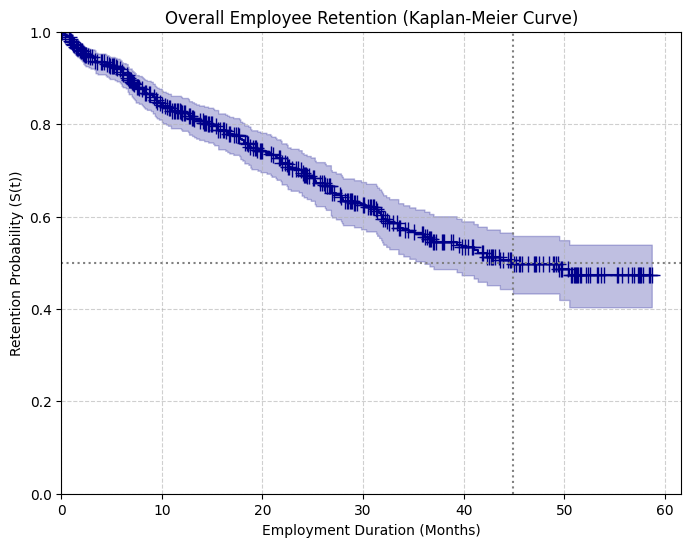

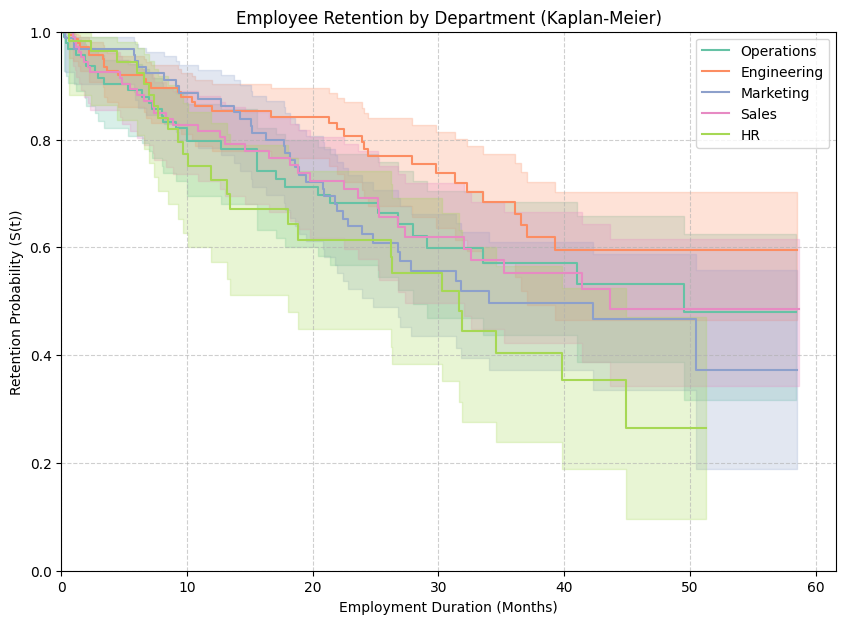

In [22]:
# Code to generate the Kaplan-Meier plot for Part 1.c
kmf_overall_plot_code = """
kmf_overall = KaplanMeierFitter()
kmf_overall.fit(retention_data['time'], event_observed=retention_data['event'])

plt.figure(figsize=(8, 6))
kmf_overall.plot_survival_function(
    show_censors=True, 
    ci_show=True, 
    legend=False,
    color='darkblue'
)
plt.title('Overall Employee Retention (Kaplan-Meier Curve)')
plt.xlabel('Employment Duration (Months)')
plt.ylabel('Retention Probability (S(t))')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(left=0)
plt.ylim(0, 1)
plt.axhline(0.5, color='gray', linestyle=':')
plt.axvline(kmf_overall.median_survival_time_, color='gray', linestyle=':')
plt.savefig('overall_retention_km_plot.png')
"""

# Code to generate the stratified Kaplan-Meier plot for Part 2.b
kmf_stratified_plot_code = """
departments = retention_data['department'].unique()
kmf_dict = {}

# Fit K-M estimator for each department
for dept in departments:
    dept_data = retention_data[retention_data['department'] == dept]
    kmf = KaplanMeierFitter()
    kmf.fit(dept_data['time'], event_observed=dept_data['event'], label=dept)
    kmf_dict[dept] = kmf

plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

colors = sns.color_palette("Set2", len(departments))
color_map = dict(zip(departments, colors))

for dept, kmf in kmf_dict.items():
    kmf.plot_survival_function(ax=ax, ci_show=True, color=color_map[dept])

plt.title('Employee Retention by Department (Kaplan-Meier)')
plt.xlabel('Employment Duration (Months)')
plt.ylabel('Retention Probability (S(t))')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(left=0)
plt.ylim(0, 1)
plt.savefig('stratified_retention_km_plot.png')
"""

# Execute the code to generate the plots
# First, ensure the data is generated
retention_data = generate_employee_retention_data(n=500)
# Then, execute plot code
print("Executing plot generation for Overall Retention...")
exec(kmf_overall_plot_code)
print("Executing plot generation for Stratified Retention...")
exec(kmf_stratified_plot_code)